In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

from fredapi import Fred

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

In [168]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv")
data

,date,currency_rate,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
0,1992-07-31,141.556000,1992.0,3.0,7.0,16.000000,4.000000,0.0,2.928888,pre,0.141556,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
1,1992-08-31,168.162500,1992.0,3.0,8.0,16.500000,4.000000,0.0,3.274988,pre,0.168162,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425
2,1992-09-30,220.488889,1992.0,3.0,9.0,15.333333,3.888889,0.0,2.546404,pre,0.220489,3098.802734,20.18,1490.418425,1.161000e+09,1490.418425
3,1992-10-31,353.777778,1992.0,4.0,10.0,16.666667,4.111111,0.0,5.348118,pre,0.353778,3098.802734,19.13,1490.418425,1.161000e+09,1490.418425
4,1992-11-30,426.250000,1992.0,4.0,11.0,15.500000,4.000000,0.0,1.491099,pre,0.426250,3098.802734,19.25,1490.418425,1.161000e+09,1490.418425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2025-04-30,83.243645,2025.0,2.0,4.0,15.318182,2.954545,0.0,-0.213785,post,83.243645,14260.000000,63.37,8.200000,3.300000e+09,8.140000
394,2025-05-31,80.237650,2025.0,2.0,5.0,17.150000,3.000000,0.0,-0.178412,post,80.237650,14260.000000,64.32,8.200000,3.300000e+09,8.140000
395,2025-06-30,78.677635,2025.0,2.0,6.0,15.400000,2.850000,0.0,-0.004909,post,78.677635,14260.000000,68.15,8.200000,3.300000e+09,8.140000
396,2025-07-31,78.850139,2025.0,3.0,7.0,16.000000,3.000000,0.0,0.101659,post,78.850139,14260.000000,73.43,8.200000,3.300000e+09,8.140000


## 1. Checking stationarity

#### With Classical decomposition

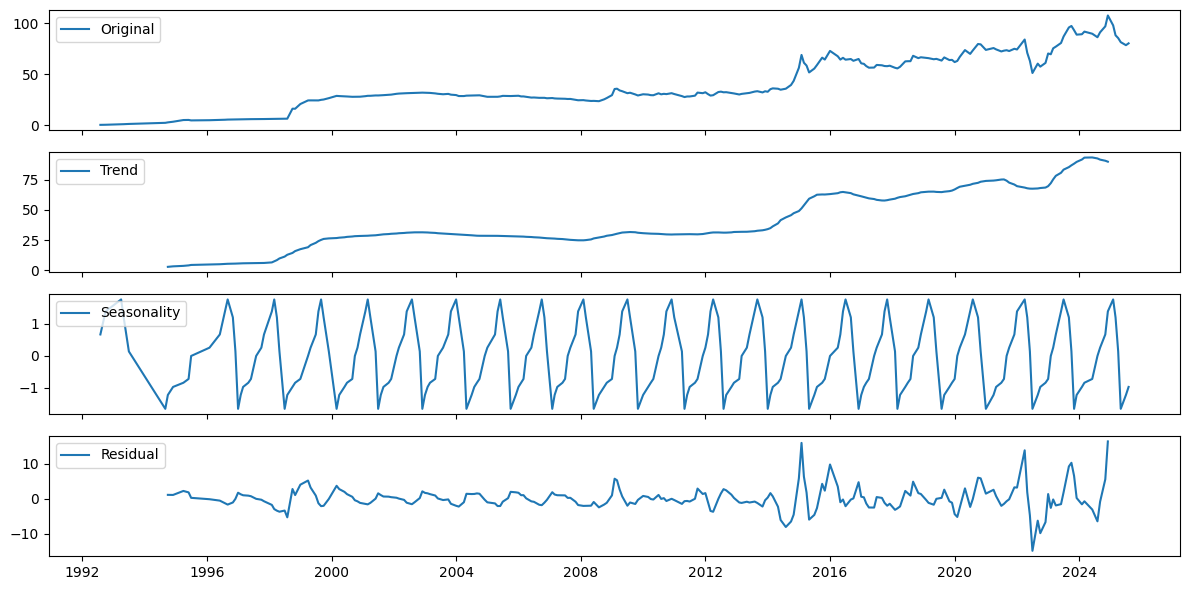

In [169]:
data_decomp = data.copy()
data_decomp['date'] = pd.to_datetime(data_decomp['date'])
data_decomp = data_decomp.sort_values('date')
data_decomp = data_decomp.set_index('date')

# secompose with period=12 (monthly seasonality)
decomposition = seasonal_decompose(rub_series, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(decomposition.trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(decomposition.resid, label='Residual')
axes[3].legend(loc='upper left')
plt.tight_layout()
plt.show()

#### With Seasonal-Trend decomposition using LOESS (STL) decomposition

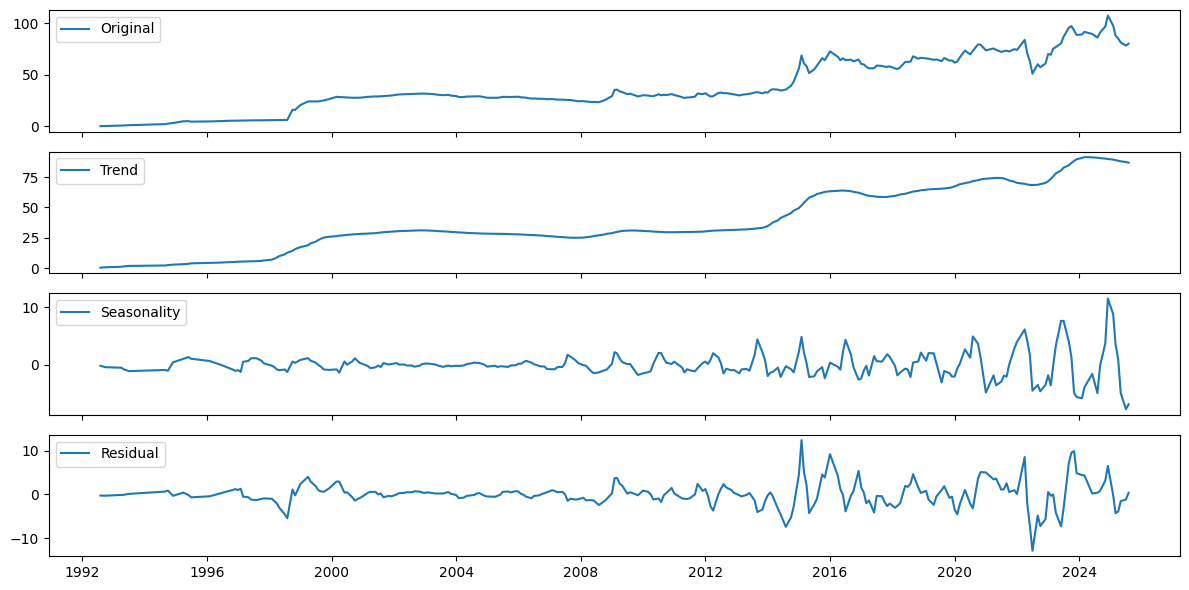

In [170]:
stl = STL(rub_series, period=12) 
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
resid = result.resid


fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(resid, label='Residual')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

STL offers superior performance for long-term, real-world financial data like exchange rates, especially when structural breaks or non-stationary behavior is present.

In [171]:
result = adfuller(data["RUB"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -0.8768242099196052
p-value: 0.7955087074195493
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}


Since the ADF statistic is higher than all critical values, and the p-value is well above 0.05, we fail to reject the null hypothesis of a unit root. This indicates that the RUB time series is non-stationary.
To proceed with time series modeling, let's apply first-order differencing to induce stationarity.

In [172]:
data.loc[:, 'RUB_diff1'] = data['RUB'].diff()  # First difference (today - yesterday)
data.loc[:, 'RUB_diff12'] = data['RUB'].diff(12)  # Seasonal difference (this month - same month last year)

rub_diff1 = data['RUB_diff1'].dropna()
result = adfuller(rub_diff1)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -13.144559968966986
p-value: 1.406932011558584e-24


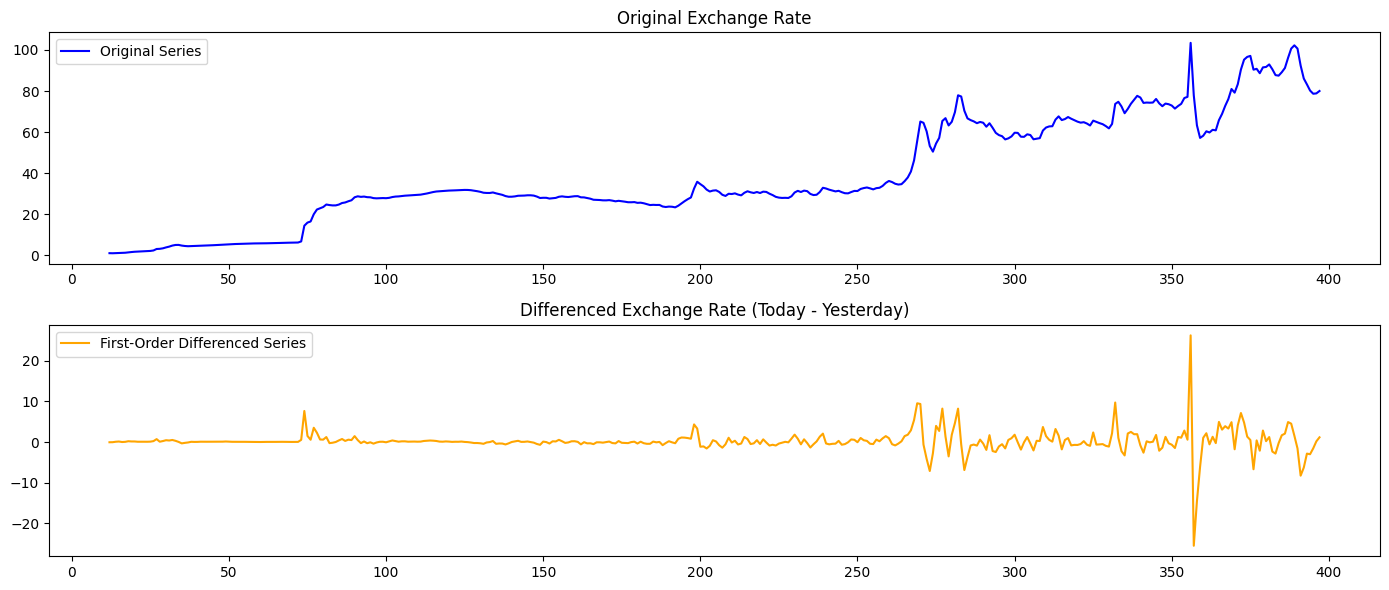

In [136]:
# First-order differencing
data['RUB_diff1'] = data['RUB'].diff()
data = data.dropna()

# Plotting both
plt.figure(figsize=(14, 6))

# Original
plt.subplot(2, 1, 1)
plt.plot(data['RUB'], label='Original Series', color='blue')
plt.title('Original Exchange Rate')
plt.legend()

# Differenced
plt.subplot(2, 1, 2)
plt.plot(data['RUB_diff1'], label='First-Order Differenced Series', color='orange')
plt.title('Differenced Exchange Rate (Today - Yesterday)')
plt.legend()

plt.tight_layout()
plt.show()

### 2. ARIMA

##### CV and Folds

In [ ]:
# = data.loc[lambda x: x["year"] == 2025, :]
#data_work = data.loc[lambda x: x["year"] < 2025, :]

In [174]:
cv_blocks = [
    (1992, 1999, 2000),
    (2000, 2007, 2008),
    (2008, 2015, 2016),
    (2016, 2023, 2024),
]

for fold, (train_start, train_end, test_year) in enumerate(cv_blocks, start=1):
    data_work.loc[:, f"train{fold}"] = (data_work["year"] >= train_start) & (data_work["year"] <= train_end)
    data_work.loc[:, f"test{fold}"] = data_work["year"] == test_year

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_82242/1778787088.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work.loc[:, f"train{fold}"] = (data_work["year"] >= train_start) & (data_work["year"] <= train_end)
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_82242/1778787088.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work.loc[:, f"test{fold}"] = data_work["year"] == test_year
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_82242/1778787088.py:9: Set

In [186]:
data_work

,date,currency_rate,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,...,RUB_diff12,train1,test1,train2,test2,train3,test3,train4,test4,holdout
0,1992-07-31,141.556000,1992.0,3.0,7.0,16.000000,4.000000,0.000000,2.928888,pre,...,NaN,True,False,False,False,False,False,False,False,False
1,1992-08-31,168.162500,1992.0,3.0,8.0,16.500000,4.000000,0.000000,3.274988,pre,...,NaN,True,False,False,False,False,False,False,False,False
2,1992-09-30,220.488889,1992.0,3.0,9.0,15.333333,3.888889,0.000000,2.546404,pre,...,NaN,True,False,False,False,False,False,False,False,False
3,1992-10-31,353.777778,1992.0,4.0,10.0,16.666667,4.111111,0.000000,5.348118,pre,...,NaN,True,False,False,False,False,False,False,False,False
4,1992-11-30,426.250000,1992.0,4.0,11.0,15.500000,4.000000,0.000000,1.491099,pre,...,NaN,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2024-08-31,89.160161,2024.0,3.0,8.0,16.347826,4.130435,0.217391,0.245135,post,...,-6.125187,False,False,False,False,False,False,False,True,False
386,2024-09-30,91.234505,2024.0,3.0,9.0,15.500000,4.000000,0.200000,0.085003,post,...,-5.387754,False,False,False,False,False,False,False,True,False
387,2024-10-31,96.160226,2024.0,4.0,10.0,15.652174,3.869565,0.173913,0.200753,post,...,-0.962055,False,False,False,False,False,False,False,True,False
388,2024-11-30,100.687450,2024.0,4.0,11.0,15.954545,4.363636,0.272727,0.479755,post,...,10.274660,False,False,False,False,False,False,False,True,False


In [175]:
data_work = data_work.copy()
data_work["holdout"] = data_work["year"] == 2025

In [183]:
data_holdout.shape

(8, 18)

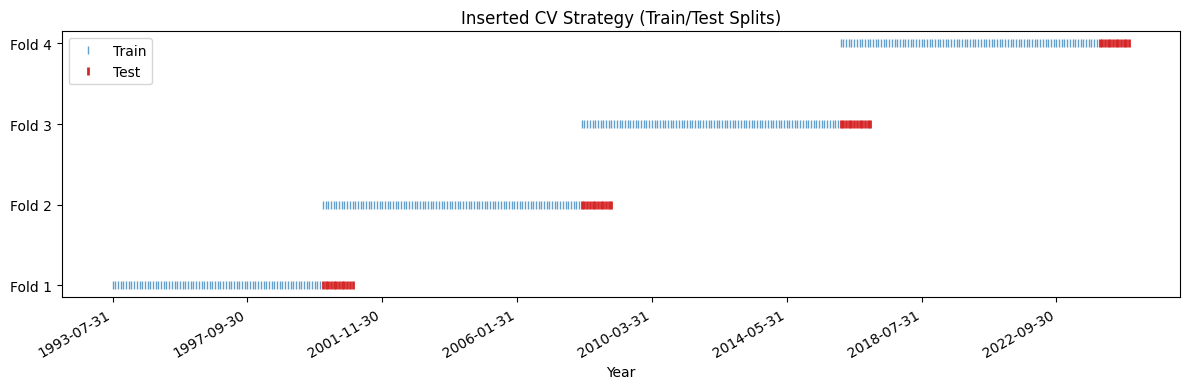

In [150]:
fig, ax = plt.subplots(figsize=(12, 4))

for fold in range(1, 5):
    train_mask = data_work[f"train{fold}"]
    test_mask  = data_work[f"test{fold}"]

    # Train
    ax.plot(
        data_work.loc[train_mask, "date"], 
        [fold] * train_mask.sum(), 
        '|', 
        color='tab:blue', 
        label="Train" if fold == 1 else "", 
        alpha=0.7
    )

    # Test
    ax.plot(
        data_work.loc[test_mask, "date"], 
        [fold] * test_mask.sum(), 
        '|', 
        color='tab:red', 
        label="Test" if fold == 1 else "", 
        markeredgewidth=2
    )

# Formatting
ax.set_yticks(range(1, 5))
ax.set_yticklabels([f"Fold {i}" for i in range(1, 5)])
ax.set_xlabel("Year")
ax.set_title("Inserted CV Strategy (Train/Test Splits)")
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

#### 2.1 Auto Arima with no Intercept

In [153]:
#Auto_arima with no intercept (trend='n')

model_1 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    trend='n'            
)


best_order = model_1.order  #
print("Best ARIMA order:", best_order)

mse_2 = []

for i in range(1, 5):
    
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    
    model_cv = ARIMA(endog=y_train, order=best_order, trend='n').fit()  # Avoid overwriting model_1


    phat = model_cv.forecast(steps=len(y_test))

   
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))


rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1839.675, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1835.175, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1834.694, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1839.675, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1836.690, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1836.678, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1835.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1834.694, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.104 seconds
Best ARIMA order: (0, 1, 1)
CV RMSE (Auto ARIMA): 4.7115897855922695
     lb_stat  lb_pvalue
10  1.531576   0.998834


In [154]:
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  378
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -915.347
Date:                Wed, 17 Sep 2025   AIC                           1834.694
Time:                        17:13:04   BIC                           1842.558
Sample:                             0   HQIC                          1837.815
                                - 378                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1373      0.011     12.012      0.000       0.115       0.160
sigma2         7.5234      0.132     57.168      0.000       7.265       7.781
Ljung-Box (L1) (Q):                   0.02   Jarque-

#### 2.3 Auto Arima with Intercept (t)

In [ ]:
# Auto_arima with intercept (trend='t')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings

try:
    model_2 = auto_arima(
        data_work["RUB"], 
        start_p=0, max_p=5,
        start_q=0, max_q=5,
        d=None,              
        seasonal=False,      
        stepwise=True,       
        trace=True,          
        trend='t'            
    )
except Exception as e:
    print("auto_arima failed:", e)
    raise

best_order = model_2.order
print("Best ARIMA order:", best_order)

mse_2 = []

for i in range(1, 5):
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        try:
            model_cv = ARIMA(endog=y_train, order=best_order, trend='t').fit()
        except Exception as e:
            print(f"ARIMA fit failed on fold {i}: {e}")
            mse_2.append(np.nan)
            continue
        for warning in w:
            print(f"Convergence warning on fold {i}: {warning.message}")

    phat = model_cv.forecast(steps=len(y_test))


    if np.any(np.isnan(phat.values)):
        print(f"NaN in forecast on fold {i}")
        mse_2.append(np.nan)
        continue

    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))


mse_2_clean = [m for m in mse_2 if not np.isnan(m)]
if mse_2_clean:
    rmse_cv_m2 = float(np.sqrt(np.mean(mse_2_clean)))
else:
    rmse_cv_m2 = np.nan
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)

# Check residuals only if model_cv exists and is fitted
if 'model_cv' in locals():
    try:
        print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))
    except Exception as e:
        print("Ljung-Box test failed:", e)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1837.395, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1833.833, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1833.293, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1837.395, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1835.260, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1835.165, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1834.106, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1833.293, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.527 seconds
Best ARIMA order: (0, 1, 1)
CV RMSE (Auto ARIMA): 6.11960865634312
     lb_stat  lb_pvalue
10  1.533744   0.998826


In [158]:
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  378
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -913.646
Date:                Wed, 17 Sep 2025   AIC                           1833.293
Time:                        17:16:23   BIC                           1845.089
Sample:                             0   HQIC                          1837.975
                                - 378                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0013      0.001      2.407      0.016       0.000       0.002
ma.L1          0.1297      0.013     10.161      0.000       0.105       0.155
sigma2         7.4559      0.133     56.077      0.0

In [ ]:
# 1. Define train (all before 2025) and holdout (2025)
y_train_full = data_work.loc[data_work["holdout"] == False, "RUB"].sort_index()
y_holdout    = data_work.loc[data_work["holdout"] == True,  "RUB"].sort_index()

# 2. Fit ARIMA on full training data
model_final = ARIMA(endog=y_train_full, order=best_order, trend="t").fit()

# 3. Forecast horizon = holdout length
forecast = model_final.get_forecast(steps=len(y_holdout))
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# 4. Plot actual vs forecast
plt.figure(figsize=(12,5))
plt.plot(y_train_full.index, y_train_full, label="Training", color="blue")
plt.plot(y_holdout.index, y_holdout, label="Holdout (Actual)", color="black")
plt.plot(pred_mean.index, pred_mean, label="Forecast", color="red")
plt.fill_between(pred_ci.index, 
                 pred_ci.iloc[:, 0], 
                 pred_ci.iloc[:, 1], 
                 color="pink", alpha=0.3)
plt.title("ARIMA Forecast vs Holdout")
plt.legend()
plt.show()

# 5. (Optional) Evaluate forecast accuracy
rmse_holdout = np.sqrt(((y_holdout.values - pred_mean.values) ** 2).mean())
print("Holdout RMSE:", rmse_holdout)

AssertionError: 

In [90]:
model_3 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,  
    m=12,            # Let it choose d
    seasonal=True,      
    stepwise=True,
    trace=True,
    trend=None           # Let it choose (drift if needed)
)

# 2. Extract best order
best_order = model_3.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation across 4 folds
mse_2 = []

for i in range(1, 5):
    train_mask = data_work[f"train{i}"]
    test_mask  = data_work[f"test{i}"]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Use trend='t' (linear trend) which works with d > 0
    model = ARIMA(endog=y_train, order=best_order, trend='t').fit()

    # Forecast as many steps as test set
    phat = model.forecast(steps=len(y_test))

    # Squared errors
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE across folds
rmse_cv = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (ARIMA w/ linear trend):", rmse_cv)

# 5. Optional: Check residual autocorrelation for the last fold
print(acorr_ljungbox(model.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=13418.393, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=13417.951, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13345.006, Time=1.91 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13347.242, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=13419.870, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=13346.659, Time=0.28 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=13346.945, Time=4.94 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=13346.969, Time=3.81 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=13345.029, Time=1.44 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=13348.970, Time=7.52 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=13416.555, Time=1.19 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=13344.995, Time=1.99 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=13347.032, Time=0.42 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=13346.966, Time=6.62 sec
 ARIM

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CV RMSE (ARIMA w/ linear trend): 6.409927244367966
      lb_stat  lb_pvalue
10  11.737628      0.303


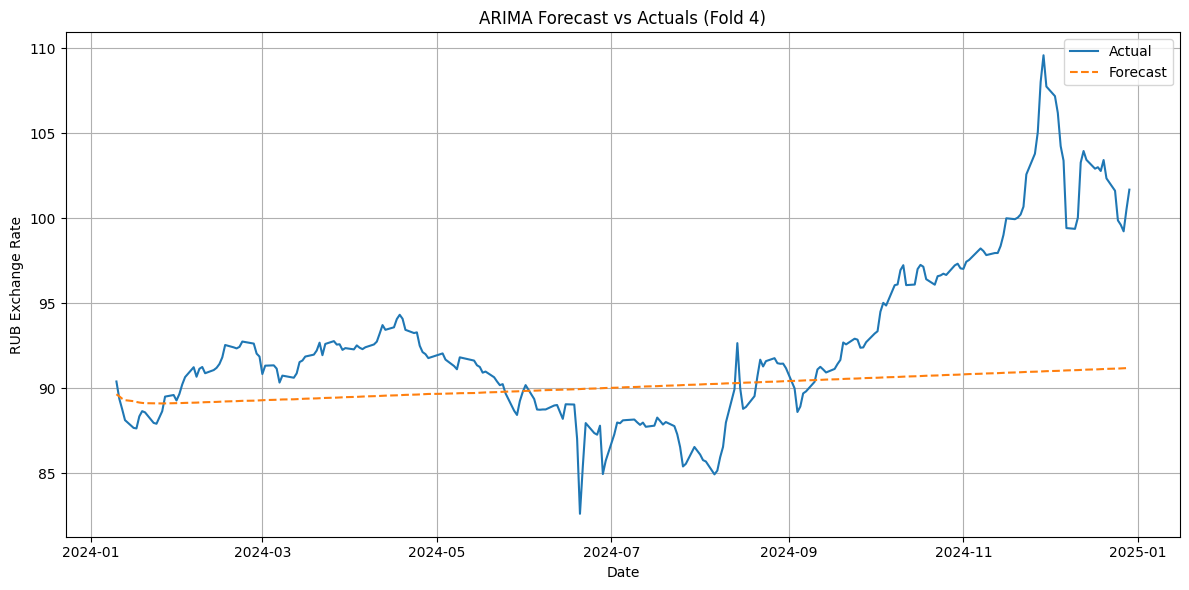

In [95]:
import matplotlib.pyplot as plt

# Get the test and predicted values for the last fold (fold 4)
last_test_mask = data_work["test4"]
y_test = data_work.loc[last_test_mask, "RUB"].sort_index()

# Refit the model on the corresponding training data for fold 4
last_train_mask = data_work["train4"]
y_train = data_work.loc[last_train_mask, "RUB"].sort_index()
model_last = ARIMA(endog=y_train, order=best_order, trend='t').fit()

# Forecast
phat = model_last.forecast(steps=len(y_test))

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, phat, label='Forecast', linestyle='--')
plt.title("ARIMA Forecast vs Actuals (Fold 4)")
plt.xlabel("Date")
plt.ylabel("RUB Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
def first_difference(data):
    data_diff = data.diff().dropna()
    return data_diff

In [129]:
data["GDP_per_capita"]

12       3098.802734
13       3098.802734
14       3098.802734
15       3098.802734
16       3098.802734
            ...     
7665    14260.000000
7666    14260.000000
7667    14260.000000
7668    14260.000000
7669    14260.000000
Name: GDP_per_capita, Length: 7658, dtype: float64

In [127]:
GDP_diff = first_difference(data["GDP_per_capita"])
GDP_diff

13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
       ... 
7665    0.0
7666    0.0
7667    0.0
7668    0.0
7669    0.0
Name: GDP_per_capita, Length: 7657, dtype: float64

In [121]:
def acf_pacf_plots(data, title):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column
    plot_acf(data, ax=axes[0], lags=20)
    axes[0].set_title(f"ACF - {title}")
    
    plot_pacf(data, ax=axes[1], lags=20, method='ywm')  # method can be changed to 'ols' if needed
    axes[1].set_title(f"PACF - {title}")
    
    plt.tight_layout()
    plt.show()

In [124]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,RUB_diff1,RUB_diff12
12,161.7000,1992-08-12,1992,3,8,12,3,False,0.123839,pre,0.1617,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0002,0.03644
13,162.5000,1992-08-14,1992,3,8,14,5,False,0.494743,pre,0.1625,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0008,0.02770
14,162.5000,1992-08-19,1992,3,8,19,3,False,0.000000,pre,0.1625,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0000,0.03200
15,162.6000,1992-08-21,1992,3,8,21,5,False,0.061538,pre,0.1626,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0001,0.03230
16,168.1000,1992-08-26,1992,3,8,26,3,False,3.382534,pre,0.1681,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,0.0055,0.03790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,14260.000000,67.83,8.200000,3.300000e+09,8.140000,0.4032,0.10930
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,14260.000000,67.83,8.200000,3.300000e+09,8.140000,-0.0790,0.01770
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,14260.000000,67.83,8.200000,3.300000e+09,8.140000,-0.2421,0.43090
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,14260.000000,67.83,8.200000,3.300000e+09,8.140000,0.1503,0.20580


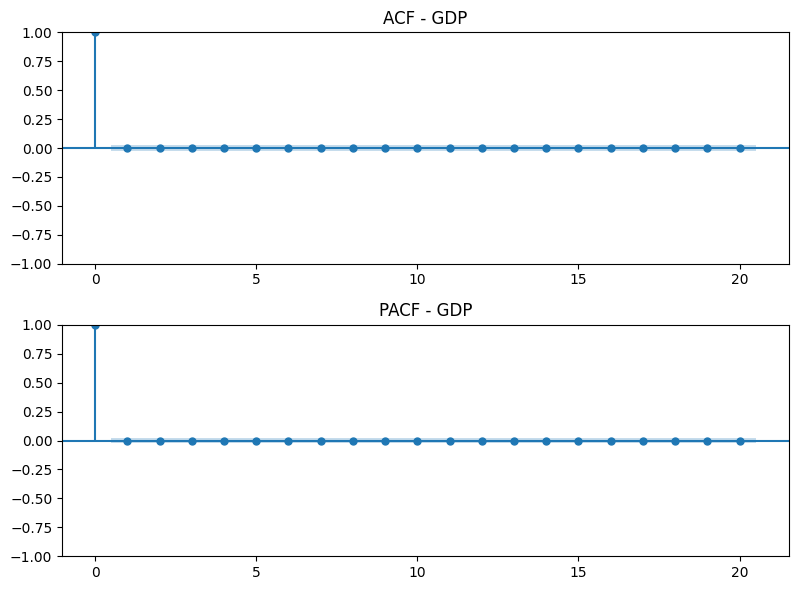

In [122]:
acf_pacf_plots(GDP_diff, "GDP")
